# AdaIN  
Huang and Belongie propose [AdaIN](https://arxiv.org/abs/1703.06868), an image style transfer architecture that aims to improve performance compared to previous works by using an adaptive instance normalization mechanism.  

Initially, the content image and the style image are passed through a pretrained VGG encoder to extract their feature maps, this will give out content feature map and style feature map.   
 
#### VGG  
![VGG Architecture](images/vgg_architecture.png)    

Visual Geometry Group(VGG) is network is a deep convolutional neural network architecture. It primarily improves image classification and feature extraction performance by using smaller convolution kernels and a deeper network structure. The fundamental building blocks of the VGG network are 3x3 convolutional kernels and 2x2 max pooling layers, small convolutional kernels can captures fine features, and stacking multiple convolutional layers mimics a larger receptive field. VGG enhances the expressiveness and accuracy of the model by increasing the network depth (more convolution layers). Deeper networks can learn more complex and advanced features. Downsampling is performed using a fixed-size 2x2 max pooling layer to gradually reduce the spatial dimension of the feature map while increasing the receptive field. This design makes it excellent in feature extraction, such as style transfer, image retrieval, etc.  

The extracted feature maps enter the AdaIN module. In this module, the mean and standard deviation of the content feature map are adjusted to match the mean and standard deviation of the style feature map, thus aligning the statistical properties of the content feature map with those of the style feature map. The adjusted feature map then passed through the decoder to generate an image with the target style. Finally, the generated image is passed through the VGG encoder again to extract features for calculating the loss.
  
To maintain the structure of the content images and characteristics of the style images, Huang and Belongie introduce content loss and style loss, content loss ensures that the content of the generated image remains similar to that of the input content image by comparing their encoded features. And style loss ensures that the style of the generated image matches that of the input style image by comparing the statistics (mean and variance) of their encoded features.  

![AdaIN Architecture](images/adain_architecture.png)

Code source from https://github.com/naoto0804/pytorch-AdaIN

# Imports

In [1]:
import torch.nn as nn
import torch
import utils.data as data
from utils.eval import compute_ssim, plot_results
import models.AdaIN as adain

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloaders

In [2]:
import torchvision.transforms as transforms

val_tf = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

_, content_validloader, _, _, style_validloader, _ = data.get_dataloaders(bs=64, valid_tf=val_tf)


# Loading pretrained model

In [3]:
decoder = adain.decoder
vgg = adain.vgg

# Pretrained model source: https://github.com/naoto0804/pytorch-AdaIN/releases/tag/v0.0.0
decoder.load_state_dict(torch.load("models/output/AdaIN/decoder.pth"))
vgg.load_state_dict(torch.load("models/output/AdaIN/vgg_normalised.pth"))
vgg = nn.Sequential(*list(vgg.children())[:31])

vgg.to(device)
decoder.to(device)

Sequential(
  (0): ReflectionPad2d((1, 1, 1, 1))
  (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (2): ReLU()
  (3): Upsample(scale_factor=2.0, mode='nearest')
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): ReflectionPad2d((1, 1, 1, 1))
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): ReflectionPad2d((1, 1, 1, 1))
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (12): ReLU()
  (13): ReflectionPad2d((1, 1, 1, 1))
  (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU()
  (16): Upsample(scale_factor=2.0, mode='nearest')
  (17): ReflectionPad2d((1, 1, 1, 1))
  (18): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (19): ReLU()
  (20): ReflectionPad2d((1, 1, 1, 1))
  (21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (22): ReLU()
  (23): Upsample(scale_factor=2.0, mode='nearest')
  (24): ReflectionPad2d((1, 1, 1, 1))
  (25): Conv2d(64

# Run model evaluation  
To evaluate model performance, we compute the structural similarity(SSIM), the content loss and the style loss

In [4]:
def adain_run(vgg, decoder, content_loader, style_loader):
    decoder.eval()
    vgg.eval()
    total_samples = 0
    running_content_loss, running_style_loss = 0.0, 0.0
    with torch.no_grad():
        for content, style in zip(content_loader, style_loader):
            content_images = content.to(device)
            style_images, style_labels = style
            style_images, style_labels = style_images.to(device), style_labels.to(device)
            
            stylised_images, content_loss, style_loss = adain.style_transfer(vgg, decoder, content_images, style_images, device=device)
            
            running_style_loss += style_loss.item()
            running_content_loss += content_loss.item()
            
            if total_samples == 0:
                plot_results(content_images, style_images, style_labels, stylised_images, model_name="AdaIN")
            total_samples += style_labels.size(0)
            
    avg_ssim = compute_ssim(content_images, stylised_images) / total_samples
    avg_content_loss = running_content_loss / total_samples
    avg_style_loss = running_style_loss / total_samples
    return avg_ssim, avg_content_loss, avg_style_loss

# Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


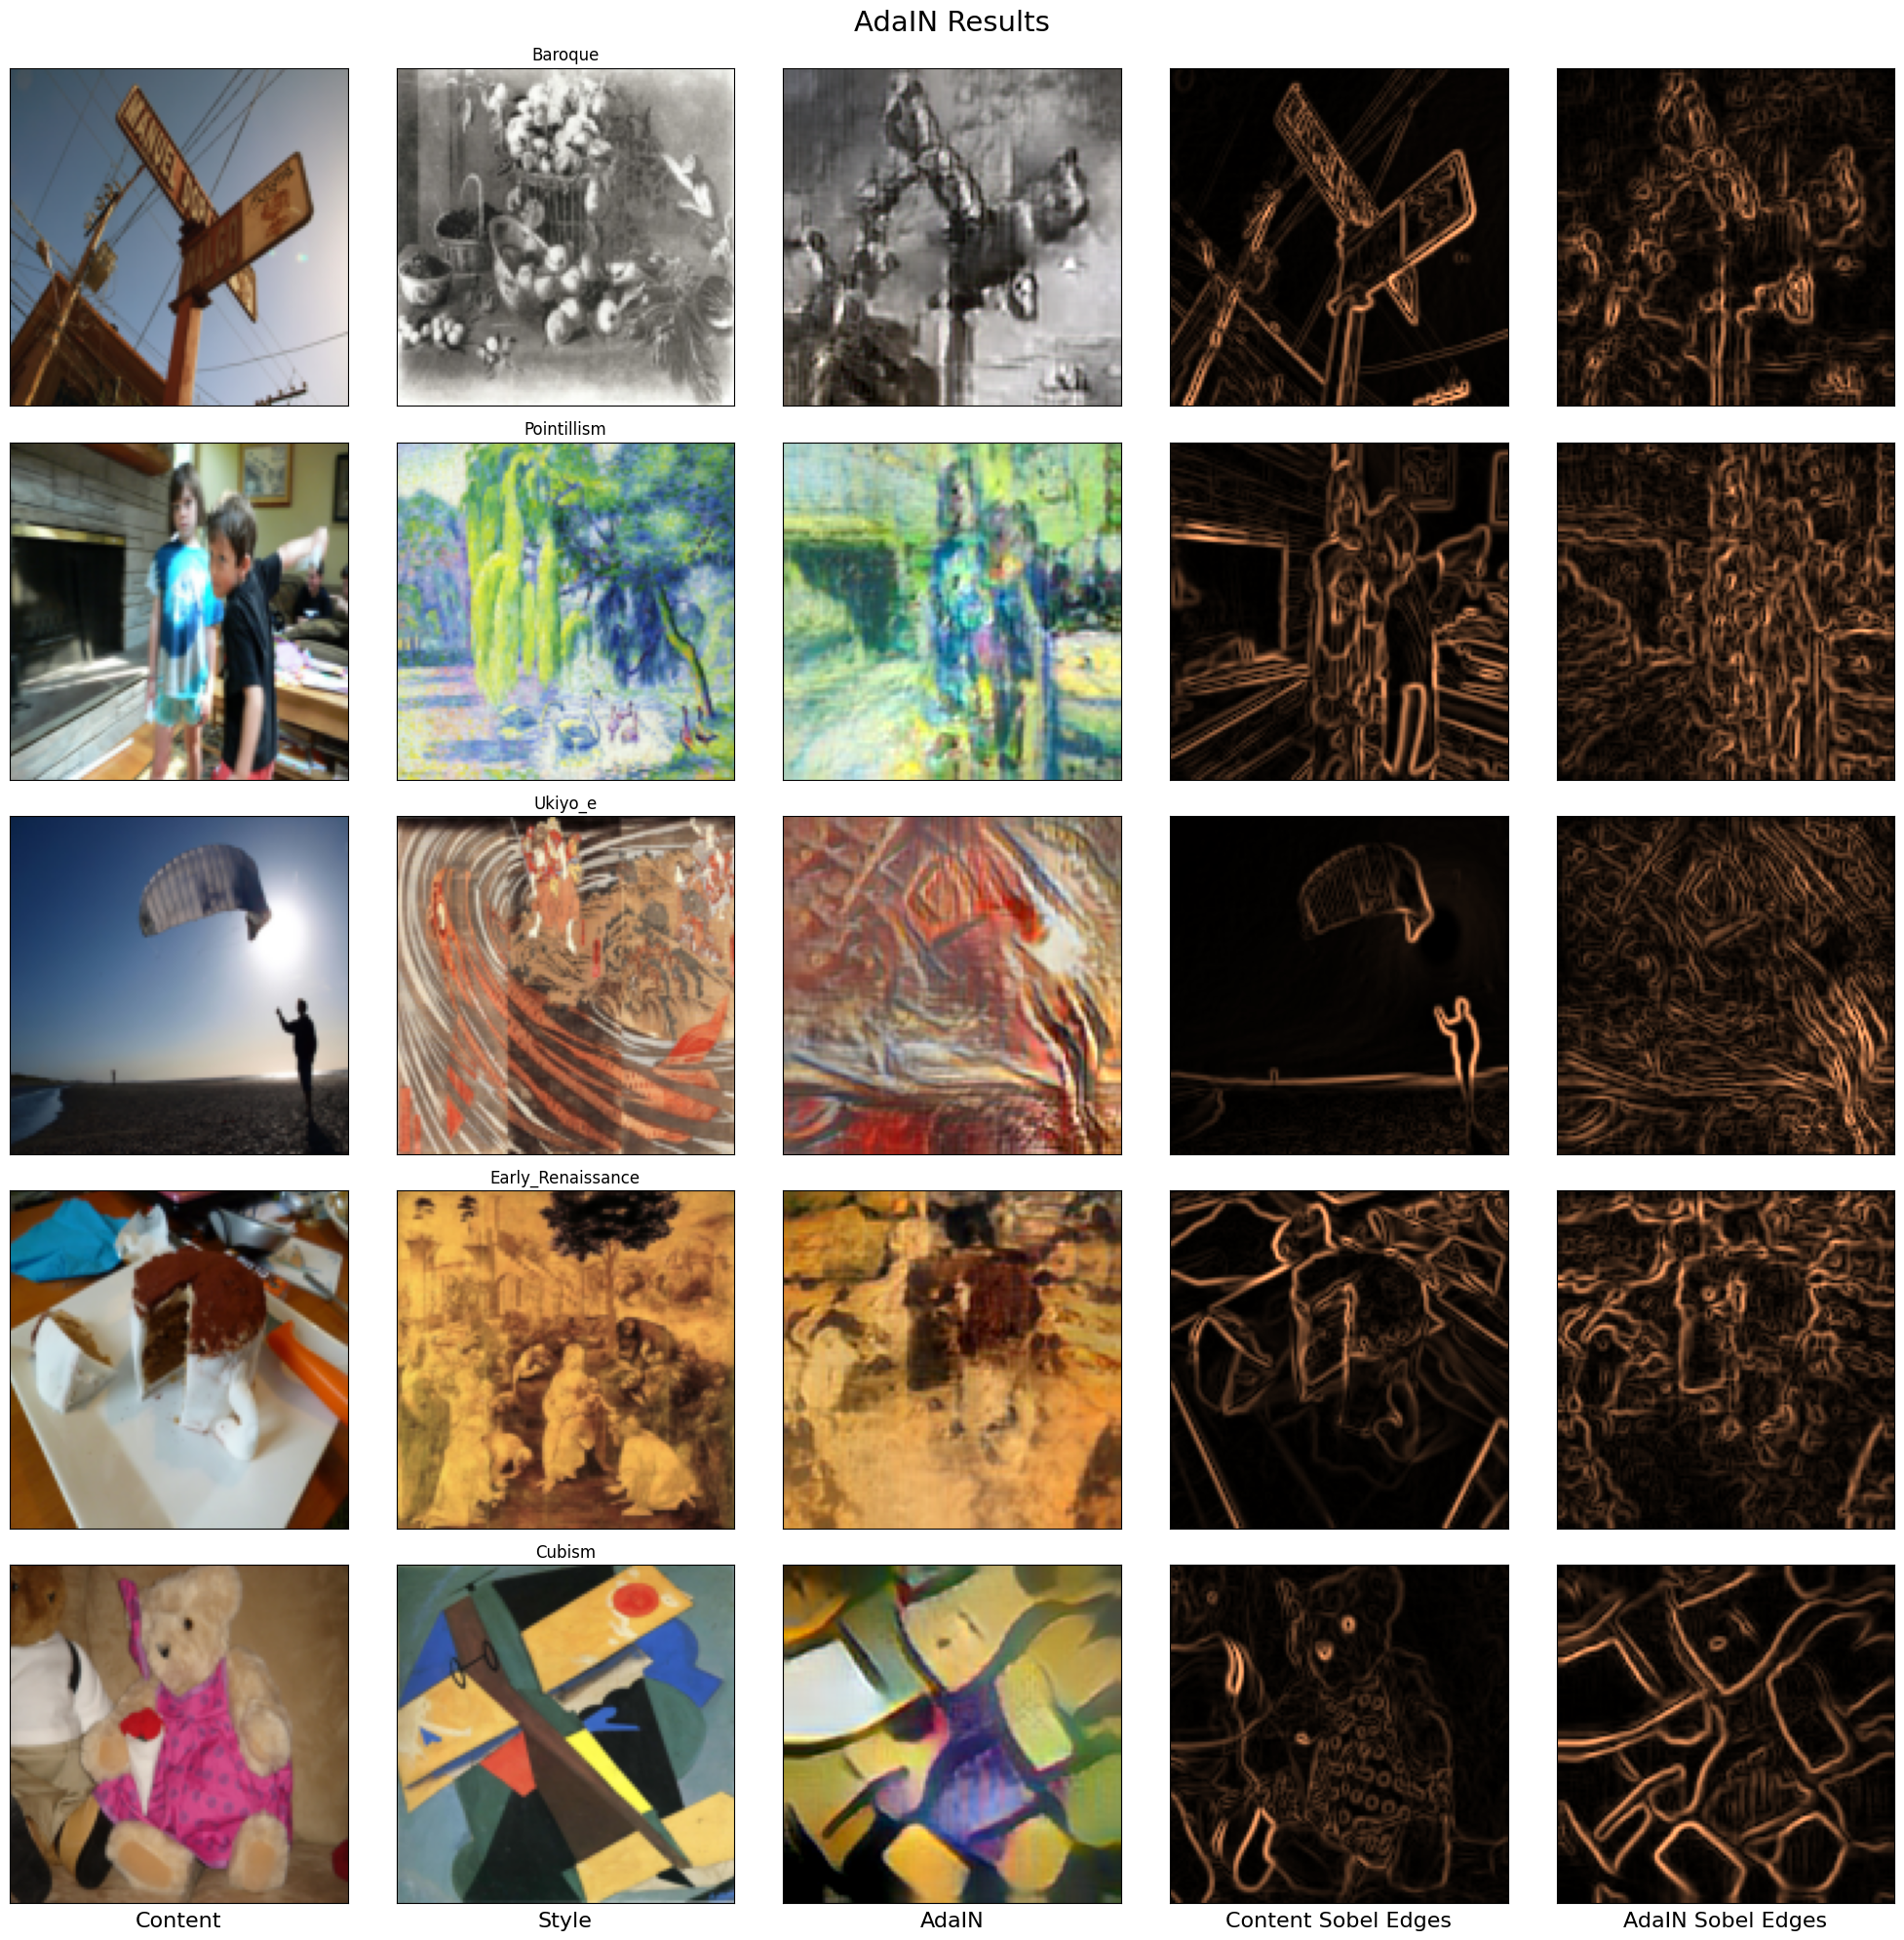

--- AdaIN results ---
Average SSIM =  0.0138
Average content loss = 0.0013
Average style loss = 0.000039


In [5]:
AdaIN_ssim, AdaIN_content_loss, AdaIN_style_loss = adain_run(vgg, decoder, content_validloader, style_validloader)
print("--- AdaIN results ---")
print(f'Average SSIM = {AdaIN_ssim: .4f}')
print(f"Average content loss = {AdaIN_content_loss:.4f}")
print(f"Average style loss = {AdaIN_style_loss:.6f}")